In [1]:
from typing import Iterable
import datetime

In [2]:
from rdkit import Chem, RDLogger
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
import rdkit
from rdkit.Chem.MolStandardize import rdMolStandardize
import polars as pl
print(rdkit.__version__)

2023.09.1


In [3]:
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

In [4]:
def enumerate_tauts(sml):
    enumerators = [rdMolStandardize.TautomerEnumerator(), rdMolStandardize.GetV1TautomerEnumerator()]
    smls_tauts = [{} for _ in enumerators]
    for i, enumerator in enumerate(enumerators):
        mol = Chem.MolFromSmiles(sml)
        tauts = enumerator.Enumerate(mol)
        for taut in tauts:
            smls_tauts[i].update({Chem.MolToSmiles(taut):taut})
    return smls_tauts

In [5]:
def check_same_keys(dict_list):
    start = datetime.datetime.now()
    # Check if the list is empty or has only one dictionary
    if len(dict_list) < 2:
        return True

    # Get the keys of the first dictionary in the list
    reference_keys = set(dict_list[0].keys())

    # Iterate through the dictionaries starting from the second one
    for dictionary in dict_list[1:]:
        # Check if the keys of each dictionary match the keys of the reference dictionary
        if set(dictionary.keys()) != reference_keys:
            # Return False if keys are not the same
            return False
    # Return True if all dictionaries have the same keys
    # print(f"check_same_keys took {datetime.datetime.now() - start} seconds")
    return True

Algorithm for processing Tautomer_database_release_3a:
1) Remove duplicate (keep only one row) Ref values--at initial inspection, seems like duplicate rows contain the same SMILES for SMILES_n OR keep all rows for a Ref, putting all the SMILES into a set 
2) For each row corresponding to a Ref,
    1) Read Size value
    2) Extract columns SMILES_n where n = 1 to Size
    3) Convert extracted SMILES_n to canonical using RDKit
    4) Use those several SMILES_n columns as experimental tautomers by creating a set of SMILES_n (or dictionary of SMILES_n:mol ?)
    5) Use only SMILES_1 to enumerate tautomers using various cheminformatics algorithms
    6) Compare experimental to cheminformatics results: Are there differences in count and canonical SMILES?

In [29]:
file_name = "../data/Tautomer_database_release_3a.xlsx"
# file_name = "../data/Tautomer_database_release_3a_first.xlsx"
sheet_name = "Tautomer_database"
# file_name = "../data/8.sk.smi"
# file_name = "../data/12.sk.smi"

In [30]:
def canon_sml_or_none(mol):
    if mol is None:
        return None
    return Chem.MolToSmiles(mol)

In [31]:
df = pl.read_excel(
    source=file_name, 
    sheet_name=sheet_name,
    read_csv_options={"infer_schema_length":10000},
    )
SMILES_columns = [col for col in df.columns if col.startswith('SMILES_')]
InChI_columns = [col for col in df.columns if col.startswith('Std_InChI_')]

numbered_columns = []
for i, SMILES_column in enumerate(SMILES_columns):
    numbered_columns.append(SMILES_column)
    numbered_columns.append(InChI_columns[i])

df = df.select("Ref","Size",*numbered_columns)

df_melted = df.melt(id_vars="Ref", value_vars=SMILES_columns[:2], value_name="sml")
df_melted
df_melted = df_melted.filter(pl.col('sml').is_not_null())

df_1 = df_melted.filter(pl.col("Ref")==1)
df_melted = df_melted.drop("variable")
df_melted = df_melted.unique()
df_melted = df_melted.with_columns(
    [
        pl.col("sml").map_elements(lambda s: Chem.MolFromSmiles(s)).alias("mol"),
    ]
)

df_melted = df_melted.with_columns(
    [
        pl.col("mol").map_elements(lambda m: canon_sml_or_none(m)).alias("canon_sml"),
    ]
)

df_melted = df_melted.drop("sml").drop_nulls()
df_melted = df_melted.unique("canon_sml")

df_melted = df_melted.sort("Ref")
with pl.Config(fmt_str_lengths=1000):
    print(df_melted)

shape: (3_465, 3)
┌──────┬──────────────────────────────────┬────────────────────────────────────────────────────────┐
│ Ref  ┆ mol                              ┆ canon_sml                                              │
│ ---  ┆ ---                              ┆ ---                                                    │
│ i64  ┆ object                           ┆ str                                                    │
╞══════╪══════════════════════════════════╪════════════════════════════════════════════════════════╡
│ 1    ┆ <rdkit.Chem.rdchem.Mol object at ┆ CC(=O)/C=C(/C)O                                        │
│      ┆ 0x12eff1ee0>                     ┆                                                        │
│ 1    ┆ <rdkit.Chem.rdchem.Mol object at ┆ CC(=O)CC(C)=O                                          │
│      ┆ 0x12efead50>                     ┆                                                        │
│ 2    ┆ <rdkit.Chem.rdchem.Mol object at ┆ c1c[nH]nn1                   

In [32]:
def smls_tauts(
        enumerator,
        mol,
    ):
    tauts = enumerator.Enumerate(mol)
    tauts_dict = dict()
    for taut in tauts:
        tauts_dict.update({Chem.MolToSmiles(taut):taut})
    return tauts_dict

In [33]:
def tauts_list(
        enumerator,
        mol,
    ):
    tauts = enumerator.Enumerate(mol)
    tauts_list = []
    for taut in tauts:
        tauts_list.append(taut)
    return tauts_list

In [34]:
enumerators = [rdMolStandardize.TautomerEnumerator, rdMolStandardize.GetV1TautomerEnumerator]
# df_melted = df_melted.with_columns(
#     [
#         pl.col("mol").map_elements(lambda mol: mol).alias("mol_again"),
#     ]
# )

mol = df_melted[0]["mol"].item()
print(mol)
# smls_tauts(rdMolStandardize.TautomerEnumerator, mol)

# for row in df_melted.iter_rows(named=True):
#     mol = row["mol"]
#     s_t = smls_tauts(rdMolStandardize.TautomerEnumerator(), mol)
#     print(s_t)

enumerators = [rdMolStandardize.TautomerEnumerator, rdMolStandardize.GetV1TautomerEnumerator]
for i, enumerator in enumerate(enumerators):
    df_melted = df_melted.with_columns(
        [
            pl.col("mol").map_elements(lambda m: tauts_list(enumerator(), m)).alias("tauts" + enumerator.__name__),
        ]
    )
# df_melted = df_melted.with_columns(
#     [
#         pl.col("tauts").map_elements(lambda t: len(t)).alias("n_tauts"),
#     ]
# )

df_melted

Ref,mol,canon_sml,tautsTautomerEnumerator,tautsGetV1TautomerEnumerator
i64,object,str,list[extension],list[extension]
1,<rdkit.Chem.rdchem.Mol object at 0x12eff1ee0>,"""CC(=O)/C=C(/C)…","[<rdkit.Chem.rdchem.Mol object at 0x12effa030>, <rdkit.Chem.rdchem.Mol object at 0x12eff89e0>, … <rdkit.Chem.rdchem.Mol object at 0x12eff8e40>]","[<rdkit.Chem.rdchem.Mol object at 0x2949d1d20>, <rdkit.Chem.rdchem.Mol object at 0x2949d1d90>, … <rdkit.Chem.rdchem.Mol object at 0x2949d1ee0>]"
1,<rdkit.Chem.rdchem.Mol object at 0x12efead50>,"""CC(=O)CC(C)=O""","[<rdkit.Chem.rdchem.Mol object at 0x12eff8f20>, <rdkit.Chem.rdchem.Mol object at 0x12eff9000>, … <rdkit.Chem.rdchem.Mol object at 0x12effaab0>]","[<rdkit.Chem.rdchem.Mol object at 0x2949d1f50>, <rdkit.Chem.rdchem.Mol object at 0x2949d1fc0>, … <rdkit.Chem.rdchem.Mol object at 0x2949d2110>]"
2,<rdkit.Chem.rdchem.Mol object at 0x12efdf4c0>,"""c1c[nH]nn1""","[<rdkit.Chem.rdchem.Mol object at 0x12effb300>, <rdkit.Chem.rdchem.Mol object at 0x12effb4c0>]","[<rdkit.Chem.rdchem.Mol object at 0x2949d2180>, <rdkit.Chem.rdchem.Mol object at 0x2949d21f0>]"
2,<rdkit.Chem.rdchem.Mol object at 0x12ff87450>,"""c1cn[nH]n1""","[<rdkit.Chem.rdchem.Mol object at 0x12effb680>, <rdkit.Chem.rdchem.Mol object at 0x12effbae0>]","[<rdkit.Chem.rdchem.Mol object at 0x2949d2260>, <rdkit.Chem.rdchem.Mol object at 0x2949d22d0>]"
3,<rdkit.Chem.rdchem.Mol object at 0x12ff929d0>,"""Cc1cc[nH]n1""","[<rdkit.Chem.rdchem.Mol object at 0x12cdd5770>, <rdkit.Chem.rdchem.Mol object at 0x12ff04190>]","[<rdkit.Chem.rdchem.Mol object at 0x2949d2340>, <rdkit.Chem.rdchem.Mol object at 0x2949d23b0>, … <rdkit.Chem.rdchem.Mol object at 0x2949d2500>]"
3,<rdkit.Chem.rdchem.Mol object at 0x129f87530>,"""Cc1ccn[nH]1""","[<rdkit.Chem.rdchem.Mol object at 0x12ff042e0>, <rdkit.Chem.rdchem.Mol object at 0x12ff043c0>]","[<rdkit.Chem.rdchem.Mol object at 0x2949d2570>, <rdkit.Chem.rdchem.Mol object at 0x2949d25e0>, … <rdkit.Chem.rdchem.Mol object at 0x2949d2730>]"
5,<rdkit.Chem.rdchem.Mol object at 0x12eff6570>,"""CC1(C)[C@@H]2C…","[<rdkit.Chem.rdchem.Mol object at 0x12eff9620>, <rdkit.Chem.rdchem.Mol object at 0x12ff04510>, <rdkit.Chem.rdchem.Mol object at 0x12ff04ac0>]","[<rdkit.Chem.rdchem.Mol object at 0x2949d27a0>, <rdkit.Chem.rdchem.Mol object at 0x2949d2810>, <rdkit.Chem.rdchem.Mol object at 0x2949d2880>]"
5,<rdkit.Chem.rdchem.Mol object at 0x12c90be60>,"""CC1(C)[C@@H]2C…","[<rdkit.Chem.rdchem.Mol object at 0x12ff05230>, <rdkit.Chem.rdchem.Mol object at 0x12ff05540>, <rdkit.Chem.rdchem.Mol object at 0x12ff057e0>]","[<rdkit.Chem.rdchem.Mol object at 0x2949d28f0>, <rdkit.Chem.rdchem.Mol object at 0x2949d2960>, <rdkit.Chem.rdchem.Mol object at 0x2949d29d0>]"
6,<rdkit.Chem.rdchem.Mol object at 0x12ff87530>,"""O=C(/C=C(\O)c1…","[<rdkit.Chem.rdchem.Mol object at 0x12ff058c0>, <rdkit.Chem.rdchem.Mol object at 0x12ff059a0>, … <rdkit.Chem.rdchem.Mol object at 0x12ff07990>]","[<rdkit.Chem.rdchem.Mol object at 0x2949d2a40>, <rdkit.Chem.rdchem.Mol object at 0x2949d2ab0>, … <rdkit.Chem.rdchem.Mol object at 0x2949d2ff0>]"


In [35]:
# Optional--Checking data quality
df_1 = df.filter(pl.col("Ref")==1).select("Ref","Size",*numbered_columns[:4])
df_1
df_1_InChI = df_1.select("Ref",*InChI_columns[:2])
df_1_InChI = (
    df_1_InChI
    .melt(id_vars="Ref", value_vars=InChI_columns[:2], value_name="InChI")
    .select("InChI")
    .drop_nulls()
)
unique_InChI = set(df_1_InChI["InChI"].to_list())
print(f"{unique_InChI=}")

df_1_smls = df_1.select("Ref",*SMILES_columns[:2])

df_1_smls = (
    df_1_smls
    .melt(id_vars="Ref", value_vars=SMILES_columns[:2], value_name="sml")
    .select("sml")
    .drop_nulls()
)
unique_smls = df_1_smls["sml"].to_list()
unique_mols = [Chem.MolFromSmiles(sml) for sml in unique_smls]
unique_smls_canon = {Chem.MolToSmiles(mol) for mol in unique_mols}
unique_smls_to_inchi = {Chem.MolToInchi(mol) for mol in unique_mols}

print(f"{unique_smls_canon=}")
print(f"{unique_smls_to_inchi=}")

unique_InChI={'InChI=1S/C5H8O2/c1-4(6)3-5(2)7/h3H2,1-2H3', 'InChI=1S/C5H8O2/c1-4(6)3-5(2)7/h3,6H,1-2H3/b4-3-'}
unique_smls_canon={'CC(=O)CC(C)=O', 'CC(=O)/C=C(/C)O'}
unique_smls_to_inchi={'InChI=1S/C5H8O2/c1-4(6)3-5(2)7/h3H2,1-2H3', 'InChI=1S/C5H8O2/c1-4(6)3-5(2)7/h3,6H,1-2H3/b4-3-'}


Hi

In [36]:
sml = "N=c1[nH]cc[nH]1"
smls_tauts = enumerate_tauts(sml)
smls_tauts
# check_same_keys(smls_tauts)

[{'N=c1[nH]cc[nH]1': <rdkit.Chem.rdchem.Mol at 0x12daae8f0>,
  'Nc1ncc[nH]1': <rdkit.Chem.rdchem.Mol at 0x12daae960>},
 {'N=c1[nH]cc[nH]1': <rdkit.Chem.rdchem.Mol at 0x12daae880>,
  'Nc1ncc[nH]1': <rdkit.Chem.rdchem.Mol at 0x12daaea40>}]

In [37]:
for i in range(0,1000):
    smls_tauts = enumerate_tauts(sml)

[{'N=c1[nH]cc[nH]1': <rdkit.Chem.rdchem.Mol object at 0x12daaec70>, 'Nc1ncc[nH]1': <rdkit.Chem.rdchem.Mol object at 0x12daaec00>}, {'N=c1[nH]cc[nH]1': <rdkit.Chem.rdchem.Mol object at 0x12daaedc0>, 'Nc1ncc[nH]1': <rdkit.Chem.rdchem.Mol object at 0x12daaed50>}]
[['N=c1[nH]cc[nH]1', 'Nc1ncc[nH]1'], ['N=c1[nH]cc[nH]1', 'Nc1ncc[nH]1']]
[[<rdkit.Chem.rdchem.Mol object at 0x12daaec70>, <rdkit.Chem.rdchem.Mol object at 0x12daaec00>], [<rdkit.Chem.rdchem.Mol object at 0x12daaedc0>, <rdkit.Chem.rdchem.Mol object at 0x12daaed50>]]


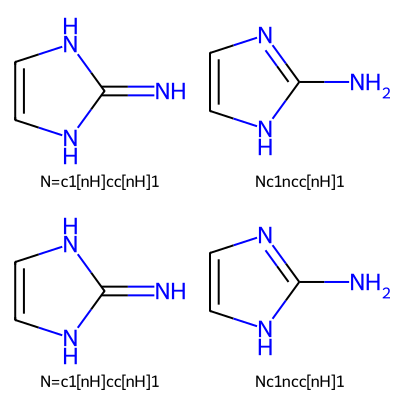

In [38]:
sml = "N=c1[nH]cc[nH]1"
smls_tauts = enumerate_tauts(sml)
print(smls_tauts)
smls = [[item for item in enumerator.keys()] for enumerator in smls_tauts]
tauts = [[item for item in enumerator.values()] for enumerator in smls_tauts]

print(smls)
print(tauts)
Draw.MolsMatrixToGridImage(tauts, legendsMatrix=smls)